In [4]:
# Only with Google colab
import sys
from google.colab import drive
drive.mount('/content/gdrive')
sys.path.append("/content/gdrive/My Drive/Colab Notebooks")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Imports

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential, load_model
from keras.callbacks import History, ModelCheckpoint, EarlyStopping
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.applications import VGG16

from utils import load_images, plot_accuracy_and_loss, plot_confusion_matrix, plot_smoothed_acc_and_loss, extract_features

Using TensorFlow backend.


# Parameters

In [2]:
train_dir = 'images_small/train/'
validation_dir = 'images_small/validation/'
test_dir = 'images_small/test/'

STD_SIZE = (100, 100)
BATCH_SIZE = 20
ENVIRONNEMENT = 'local'

if ENVIRONNEMENT == 'colab':
    PATH = '/content/gdrive/My Drive/Colab Notebooks/'
else:
    PATH = ''

# 2 breeds

### Data preparation

In [3]:
classes = ['Chihuahua', 'Japanese_spaniel']

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

with open('classes_encoding_2', 'wb') as f:
    pickle.dump(classes_labels, f)

Found 202 images belonging to 2 classes.
Found 67 images belonging to 2 classes.
Found 68 images belonging to 2 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel']

Loaded test images in test_features array: (68, 100, 100, 3)


### Model

In [4]:
model = load_model(PATH + 'tl_freeze_conv_base_data_aug_2')

W0703 09:07:21.296471  7844 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0703 09:07:21.316473  7844 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0703 09:07:21.336474  7844 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0703 09:07:21.572487  7844 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0703 09:07:21.573487  7844 de

KeyboardInterrupt: 

In [ ]:
set_trainable = False
for layer in model.layers[0].layers:
    if layer.name == 'block4_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [17]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-5),
              metrics=['accuracy'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_fine_tuning_2', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_fine_tuning_2_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 3s - loss: 8.2372 - acc: 0.4850 - val_loss: 8.8650 - val_acc: 0.4500

Epoch 00001: val_loss improved from inf to 8.86495, saving model to tl_fine_tuning_2
Epoch 2/1000
 - 3s - loss: 9.2876 - acc: 0.4238 - val_loss: 9.6023 - val_acc: 0.4043

Epoch 00002: val_loss did not improve from 8.86495
Epoch 3/1000
 - 2s - loss: 9.7755 - acc: 0.3935 - val_loss: 8.5735 - val_acc: 0.4681

Epoch 00003: val_loss improved from 8.86495 to 8.57346, saving model to tl_fine_tuning_2
Epoch 4/1000
 - 2s - loss: 8.5469 - acc: 0.4697 - val_loss: 8.5735 - val_acc: 0.4681

Epoch 00004: val_loss improved from 8.57346 to 8.57345, saving model to tl_fine_tuning_2
Epoch 5/1000
 - 2s - loss: 9.1161 - acc: 0.4344 - val_loss: 8.8650 - val_acc: 0.4500

Epoch 00005: val_loss did not improve from 8.57345
Epoch 6/1000
 - 2s - loss: 8.3755 - acc: 0.4804 - val_loss: 8.2305 - val_acc: 0.4894

Epoch 00006: val_loss improved from 8.57345 to 8.23052, saving model to tl_fine_tuning_2
Epoch 7/1000
 - 2s - loss: 7.5


Epoch 00056: val_loss did not improve from 0.04280
Epoch 57/1000
 - 2s - loss: 0.2411 - acc: 0.9243 - val_loss: 0.2521 - val_acc: 0.9167

Epoch 00057: val_loss did not improve from 0.04280
Epoch 58/1000
 - 2s - loss: 0.0178 - acc: 1.0000 - val_loss: 0.1781 - val_acc: 0.9574

Epoch 00058: val_loss did not improve from 0.04280
Epoch 59/1000
 - 2s - loss: 0.1721 - acc: 0.9647 - val_loss: 0.1580 - val_acc: 0.9362

Epoch 00059: val_loss did not improve from 0.04280
Epoch 60/1000
 - 2s - loss: 0.0778 - acc: 0.9647 - val_loss: 0.7440 - val_acc: 0.8511

Epoch 00060: val_loss did not improve from 0.04280
Epoch 61/1000
 - 2s - loss: 0.0367 - acc: 0.9748 - val_loss: 0.2870 - val_acc: 0.9833

Epoch 00061: val_loss did not improve from 0.04280
Epoch 62/1000
 - 2s - loss: 0.1801 - acc: 0.9344 - val_loss: 0.8676 - val_acc: 0.8085

Epoch 00062: val_loss did not improve from 0.04280
Epoch 63/1000
 - 2s - loss: 0.0936 - acc: 0.9697 - val_loss: 0.1679 - val_acc: 0.9787

Epoch 00063: val_loss did not imp


Epoch 00115: val_loss did not improve from 0.02788
Epoch 116/1000
 - 2s - loss: 0.0060 - acc: 1.0000 - val_loss: 0.2026 - val_acc: 0.9787

Epoch 00116: val_loss did not improve from 0.02788
Epoch 117/1000
 - 2s - loss: 0.0018 - acc: 1.0000 - val_loss: 0.2875 - val_acc: 0.9667

Epoch 00117: val_loss did not improve from 0.02788
Epoch 118/1000
 - 2s - loss: 7.3128e-04 - acc: 1.0000 - val_loss: 0.2611 - val_acc: 0.9362

Epoch 00118: val_loss did not improve from 0.02788
Epoch 119/1000
 - 2s - loss: 0.8792 - acc: 0.8935 - val_loss: 0.2116 - val_acc: 0.9787

Epoch 00119: val_loss did not improve from 0.02788
Epoch 120/1000
 - 2s - loss: 0.0758 - acc: 0.9798 - val_loss: 0.0801 - val_acc: 0.9787

Epoch 00120: val_loss did not improve from 0.02788
Epoch 121/1000
 - 2s - loss: 0.0026 - acc: 1.0000 - val_loss: 0.1171 - val_acc: 0.9500

Epoch 00121: val_loss did not improve from 0.02788
Epoch 122/1000
 - 2s - loss: 0.1957 - acc: 0.9650 - val_loss: 0.8508 - val_acc: 0.9362

Epoch 00122: val_loss 


Epoch 00173: val_loss did not improve from 0.00000
Epoch 174/1000
 - 2s - loss: 0.0455 - acc: 0.9950 - val_loss: 0.2522 - val_acc: 0.9787

Epoch 00174: val_loss did not improve from 0.00000
Epoch 175/1000
 - 2s - loss: 0.7281 - acc: 0.9238 - val_loss: 0.1364 - val_acc: 0.9574

Epoch 00175: val_loss did not improve from 0.00000
Epoch 176/1000
 - 2s - loss: 0.0785 - acc: 0.9697 - val_loss: 0.0696 - val_acc: 0.9574

Epoch 00176: val_loss did not improve from 0.00000
Epoch 177/1000
 - 2s - loss: 0.0465 - acc: 0.9850 - val_loss: 0.4010 - val_acc: 0.9333

Epoch 00177: val_loss did not improve from 0.00000
Epoch 178/1000
 - 2s - loss: 0.0290 - acc: 0.9950 - val_loss: 0.0761 - val_acc: 0.9787

Epoch 00178: val_loss did not improve from 0.00000
Epoch 179/1000
 - 2s - loss: 0.0013 - acc: 1.0000 - val_loss: 0.1683 - val_acc: 0.9787

Epoch 00179: val_loss did not improve from 0.00000
Epoch 180/1000
 - 2s - loss: 0.3061 - acc: 0.9445 - val_loss: 0.4567 - val_acc: 0.9149

Epoch 00180: val_loss did 

### Results

In [18]:
model.evaluate(test_features, test_labels)

68/68 [==============================] - 1s 10ms/step


[1.3369681694928337, 0.9117647058823529]

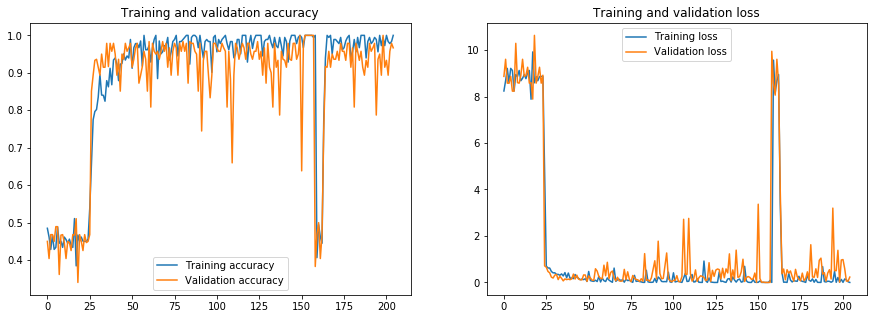

In [19]:
plot_accuracy_and_loss(history)

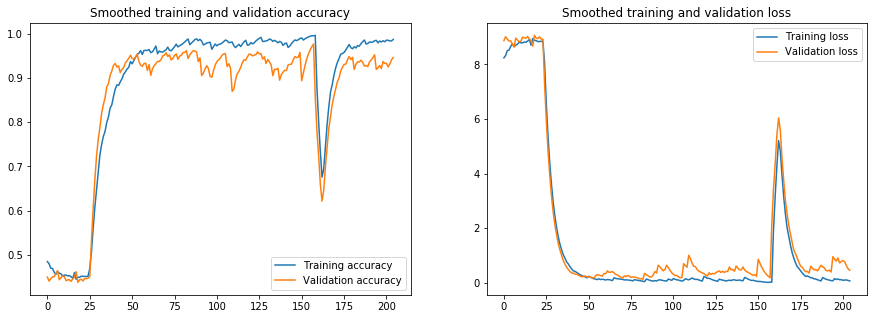

In [20]:
plot_smoothed_acc_and_loss(history, 0.8)

# 3 breeds

### Data preparation

In [4]:
classes = ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog']

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

with open('classes_encoding_3', 'wb') as f:
    pickle.dump(classes_labels, f)

Found 353 images belonging to 3 classes.
Found 117 images belonging to 3 classes.
Found 119 images belonging to 3 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog']

Loaded test images in test_features array: (119, 100, 100, 3)


### Model

In [5]:
model = load_model(PATH + 'tl_freeze_conv_base_data_aug_3')

W0703 00:55:28.381429  5832 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0703 00:55:28.401430  5832 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0703 00:55:28.424432  5832 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0703 00:55:28.649445  5832 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0703 00:55:28.649445  5832 de

In [6]:
set_trainable = False
for layer in model.layers[0].layers:
    if layer.name == 'block4_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [8]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['accuracy'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_fine_tuning_3', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_fine_tuning_3_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 4s - loss: 0.9140 - acc: 0.6996 - val_loss: 0.6108 - val_acc: 0.6907

Epoch 00001: val_loss improved from inf to 0.61077, saving model to tl_fine_tuning_3
Epoch 2/1000
 - 4s - loss: 0.5419 - acc: 0.8176 - val_loss: 0.4295 - val_acc: 0.8700

Epoch 00002: val_loss improved from 0.61077 to 0.42949, saving model to tl_fine_tuning_3
Epoch 3/1000
 - 4s - loss: 0.5035 - acc: 0.8336 - val_loss: 0.4533 - val_acc: 0.7938

Epoch 00003: val_loss did not improve from 0.42949
Epoch 4/1000
 - 4s - loss: 0.4776 - acc: 0.8011 - val_loss: 0.3634 - val_acc: 0.8351

Epoch 00004: val_loss improved from 0.42949 to 0.36344, saving model to tl_fine_tuning_3
Epoch 5/1000
 - 4s - loss: 0.4830 - acc: 0.8115 - val_loss: 0.2417 - val_acc: 0.9278

Epoch 00005: val_loss improved from 0.36344 to 0.24169, saving model to tl_fine_tuning_3
Epoch 6/1000
 - 4s - loss: 0.3348 - acc: 0.8719 - val_loss: 1.5437 - val_acc: 0.6082

Epoch 00006: val_loss did not improve from 0.24169
Epoch 7/1000
 - 4s - loss: 0.3

 - 4s - loss: 0.1271 - acc: 0.9706 - val_loss: 0.5819 - val_acc: 0.9278

Epoch 00058: val_loss did not improve from 0.08385
Epoch 59/1000
 - 4s - loss: 0.0235 - acc: 0.9897 - val_loss: 0.9551 - val_acc: 0.9072

Epoch 00059: val_loss did not improve from 0.08385
Epoch 60/1000
 - 4s - loss: 0.4061 - acc: 0.9352 - val_loss: 0.3686 - val_acc: 0.8969

Epoch 00060: val_loss did not improve from 0.08385
Epoch 61/1000
 - 4s - loss: 0.1055 - acc: 0.9676 - val_loss: 0.2604 - val_acc: 0.9381

Epoch 00061: val_loss did not improve from 0.08385
Epoch 62/1000
 - 4s - loss: 0.0353 - acc: 0.9912 - val_loss: 0.6407 - val_acc: 0.9100

Epoch 00062: val_loss did not improve from 0.08385
Epoch 63/1000
 - 4s - loss: 0.2176 - acc: 0.9381 - val_loss: 0.1417 - val_acc: 0.9485

Epoch 00063: val_loss did not improve from 0.08385
Epoch 64/1000
 - 4s - loss: 0.0300 - acc: 0.9882 - val_loss: 0.4836 - val_acc: 0.9278

Epoch 00064: val_loss did not improve from 0.08385
Epoch 65/1000
 - 4s - loss: 0.2045 - acc: 0.9749

### Results

In [9]:
model.evaluate(test_features, test_labels)

119/119 [==============================] - 3s 22ms/step


[0.3681195373294734, 0.9327731037340244]

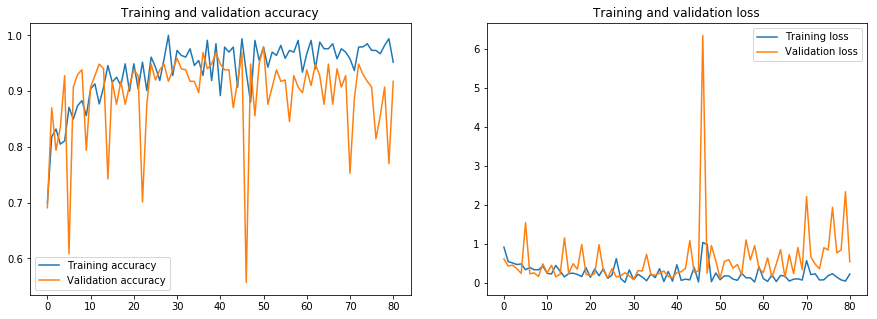

In [10]:
plot_accuracy_and_loss(history)

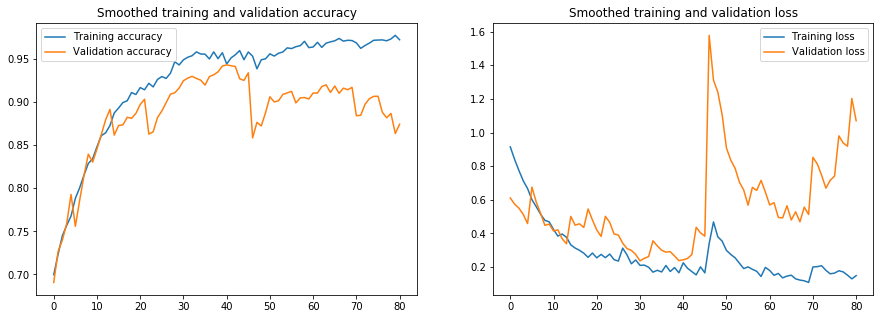

In [11]:
plot_smoothed_acc_and_loss(history, 0.8)

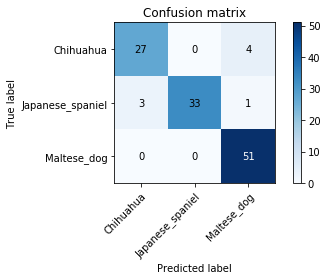

In [12]:
plot_confusion_matrix(y_true=np.argmax(test_labels, axis=-1), 
                      y_pred=model.predict_classes(test_features), 
                      classes=classes_labels)
plt.show()

# 5 breeds

### Data preparation

In [13]:
classes = ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih']

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

with open('classes_encoding_5', 'wb') as f:
    pickle.dump(classes_labels, f)

Found 570 images belonging to 5 classes.
Found 190 images belonging to 5 classes.
Found 192 images belonging to 5 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih']

Loaded test images in test_features array: (192, 100, 100, 3)


### Model

In [6]:
model = load_model(PATH + 'tl_freeze_conv_base_data_aug_5')

c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\engine\saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [7]:
set_trainable = False
for layer in model.layers[0].layers:
    if layer.name == 'block4_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [8]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['accuracy'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_fine_tuning_5', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_fine_tuning_5_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 9s - loss: 2.2773 - acc: 0.2911 - val_loss: 1.5865 - val_acc: 0.2444

Epoch 00001: val_loss improved from inf to 1.58648, saving model to tl_fine_tuning_5
Epoch 2/1000
 - 7s - loss: 1.5757 - acc: 0.2803 - val_loss: 1.3552 - val_acc: 0.4059

Epoch 00002: val_loss improved from 1.58648 to 1.35519, saving model to tl_fine_tuning_5
Epoch 3/1000
 - 6s - loss: 1.5450 - acc: 0.3608 - val_loss: 1.3328 - val_acc: 0.4765

Epoch 00003: val_loss improved from 1.35519 to 1.33284, saving model to tl_fine_tuning_5
Epoch 4/1000
 - 6s - loss: 1.2999 - acc: 0.4769 - val_loss: 1.1331 - val_acc: 0.6118

Epoch 00004: val_loss improved from 1.33284 to 1.13314, saving model to tl_fine_tuning_5
Epoch 5/1000
 - 6s - loss: 1.2175 - acc: 0.5251 - val_loss: 1.0153 - val_acc: 0.5353

Epoch 00005: val_loss improved from 1.13314 to 1.01526, saving model to tl_fine_tuning_5
Epoch 6/1000
 - 6s - loss: 1.1414 - acc: 0.5572 - val_loss: 0.8872 - val_acc: 0.7059

Epoch 00006: val_loss improved from 1.01526

 - 6s - loss: 0.3388 - acc: 0.9019 - val_loss: 1.6099 - val_acc: 0.6118

Epoch 00056: val_loss did not improve from 0.51613
Epoch 57/1000
 - 6s - loss: 0.3389 - acc: 0.9339 - val_loss: 0.8978 - val_acc: 0.7941

Epoch 00057: val_loss did not improve from 0.51613
Epoch 58/1000
 - 6s - loss: 0.2433 - acc: 0.9322 - val_loss: 1.4770 - val_acc: 0.7000

Epoch 00058: val_loss did not improve from 0.51613
Epoch 59/1000
 - 6s - loss: 0.1398 - acc: 0.9464 - val_loss: 1.8422 - val_acc: 0.7412

Epoch 00059: val_loss did not improve from 0.51613
Epoch 60/1000
 - 6s - loss: 0.2920 - acc: 0.9267 - val_loss: 1.0971 - val_acc: 0.7882

Epoch 00060: val_loss did not improve from 0.51613
Epoch 61/1000
 - 6s - loss: 0.4614 - acc: 0.9267 - val_loss: 1.0088 - val_acc: 0.7500

Epoch 00061: val_loss did not improve from 0.51613
Epoch 62/1000
 - 6s - loss: 0.2552 - acc: 0.9321 - val_loss: 1.1784 - val_acc: 0.7706

Epoch 00062: val_loss did not improve from 0.51613
Epoch 63/1000
 - 6s - loss: 0.3774 - acc: 0.9017


Epoch 00115: val_loss did not improve from 0.51613
Epoch 116/1000
 - 6s - loss: 0.3969 - acc: 0.9053 - val_loss: 1.0662 - val_acc: 0.7588

Epoch 00116: val_loss did not improve from 0.51613
Epoch 117/1000
 - 6s - loss: 0.3349 - acc: 0.9268 - val_loss: 0.9851 - val_acc: 0.7118

Epoch 00117: val_loss did not improve from 0.51613
Epoch 118/1000
 - 6s - loss: 0.2746 - acc: 0.9268 - val_loss: 1.8651 - val_acc: 0.6824

Epoch 00118: val_loss did not improve from 0.51613
Epoch 119/1000
 - 6s - loss: 0.5975 - acc: 0.9339 - val_loss: 1.1871 - val_acc: 0.7118

Epoch 00119: val_loss did not improve from 0.51613
Epoch 120/1000
 - 6s - loss: 0.1634 - acc: 0.9428 - val_loss: 1.4908 - val_acc: 0.7882

Epoch 00120: val_loss did not improve from 0.51613
Epoch 121/1000
 - 6s - loss: 0.1897 - acc: 0.9661 - val_loss: 6.0961 - val_acc: 0.5333

Epoch 00121: val_loss did not improve from 0.51613
Epoch 122/1000
 - 6s - loss: 0.2609 - acc: 0.9553 - val_loss: 1.5357 - val_acc: 0.7706

Epoch 00122: val_loss did 

### Results

In [9]:
model.evaluate(test_features, test_labels)

192/192 [==============================] - 2s 9ms/step


[1.0324601729710896, 0.7239583333333334]

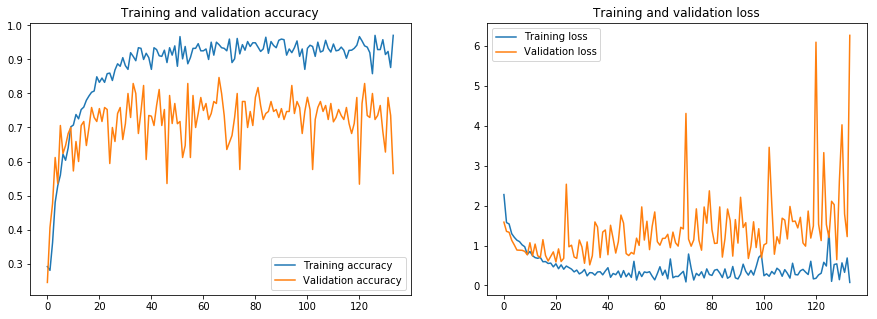

In [10]:
plot_accuracy_and_loss(history)

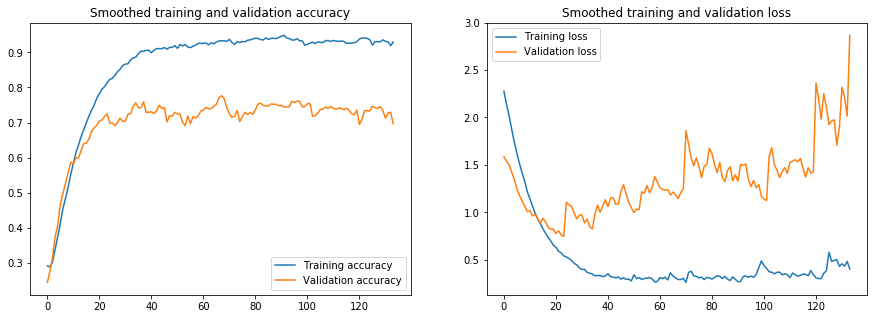

In [11]:
plot_smoothed_acc_and_loss(history, 0.8)

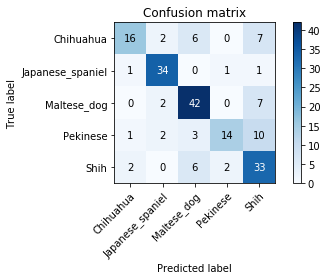

In [12]:
plot_confusion_matrix(y_true=np.argmax(test_labels, axis=-1), 
                      y_pred=model.predict_classes(test_features), 
                      classes=classes_labels)
plt.show()

# 60 breeds

### Data preparation

In [6]:
classes = os.listdir(PATH + train_dir)[:60]

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

with open('classes_encoding_60', 'wb') as f:
    pickle.dump(classes_labels, f)

Found 6046 images belonging to 60 classes.
Found 2019 images belonging to 60 classes.
Found 2046 images belonging to 60 classes.

Stored classes labels in classes_labels:  ['affenpinscher', 'Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'basenji', 'basset', 'beagle', 'Bedlington_terrier', 'Bernese_mountain_dog', 'black', 'Blenheim_spaniel', 'bloodhound', 'bluetick', 'Border_collie', 'Border_terrier', 'borzoi', 'Boston_bull', 'Bouvier_des_Flandres', 'boxer', 'Brabancon_griffon', 'briard', 'Brittany_spaniel', 'bull_mastiff', 'cairn', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly', 'Dandie_Dinmont', 'dhole', 'dingo', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'flat', 'French_bulldog', 'German_shepherd', 'German_short', 'giant_schnauzer', 'golden_retriever', 'Gordon_setter', 'Greater_Swiss_Mountain_do

### Model

In [11]:
model = load_model(PATH + 'tl_freeze_conv_base_data_aug_60')

c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\engine\saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [12]:
set_trainable = False
for layer in model.layers[0].layers:
    if layer.name == 'block4_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [13]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['accuracy'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_fine_tuning_60', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_fine_tuning_60_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 67s - loss: 3.8481 - acc: 0.0636 - val_loss: 3.6823 - val_acc: 0.0940

Epoch 00001: val_loss improved from inf to 3.68233, saving model to tl_fine_tuning_60
Epoch 2/1000
 - 67s - loss: 3.2426 - acc: 0.1579 - val_loss: 2.9445 - val_acc: 0.2091

Epoch 00002: val_loss improved from 3.68233 to 2.94452, saving model to tl_fine_tuning_60
Epoch 3/1000
 - 66s - loss: 2.9126 - acc: 0.2206 - val_loss: 2.7162 - val_acc: 0.2531

Epoch 00003: val_loss improved from 2.94452 to 2.71621, saving model to tl_fine_tuning_60
Epoch 4/1000
 - 66s - loss: 2.6908 - acc: 0.2782 - val_loss: 2.6089 - val_acc: 0.2821

Epoch 00004: val_loss improved from 2.71621 to 2.60886, saving model to tl_fine_tuning_60
Epoch 5/1000
 - 66s - loss: 2.5095 - acc: 0.3039 - val_loss: 2.6045 - val_acc: 0.3087

Epoch 00005: val_loss improved from 2.60886 to 2.60453, saving model to tl_fine_tuning_60
Epoch 6/1000
 - 66s - loss: 2.3424 - acc: 0.3540 - val_loss: 2.7365 - val_acc: 0.2976

Epoch 00006: val_loss did not im

 - 66s - loss: 1.4276 - acc: 0.6645 - val_loss: 5.9404 - val_acc: 0.2826

Epoch 00058: val_loss did not improve from 2.22984
Epoch 59/1000
 - 66s - loss: 1.4765 - acc: 0.6426 - val_loss: 3.8535 - val_acc: 0.3922

Epoch 00059: val_loss did not improve from 2.22984
Epoch 60/1000
 - 66s - loss: 1.4243 - acc: 0.6530 - val_loss: 4.3364 - val_acc: 0.3757

Epoch 00060: val_loss did not improve from 2.22984
Epoch 61/1000
 - 66s - loss: 1.4855 - acc: 0.6600 - val_loss: 3.7691 - val_acc: 0.4317

Epoch 00061: val_loss did not improve from 2.22984
Epoch 62/1000
 - 66s - loss: 1.4895 - acc: 0.6497 - val_loss: 3.5184 - val_acc: 0.4062

Epoch 00062: val_loss did not improve from 2.22984
Epoch 63/1000
 - 66s - loss: 1.5041 - acc: 0.6510 - val_loss: 8.1871 - val_acc: 0.3232

Epoch 00063: val_loss did not improve from 2.22984
Epoch 64/1000
 - 66s - loss: 1.6004 - acc: 0.6383 - val_loss: 4.4663 - val_acc: 0.3502

Epoch 00064: val_loss did not improve from 2.22984
Epoch 65/1000
 - 66s - loss: 1.4956 - acc

### Results

In [14]:
model.evaluate(test_features, test_labels)

2046/2046 [==============================] - 9s 4ms/step


[2.2144290429056563, 0.39491691113334015]

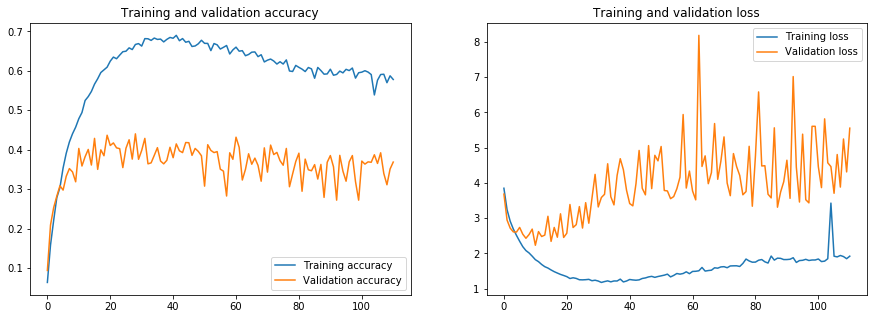

In [15]:
plot_accuracy_and_loss(history)

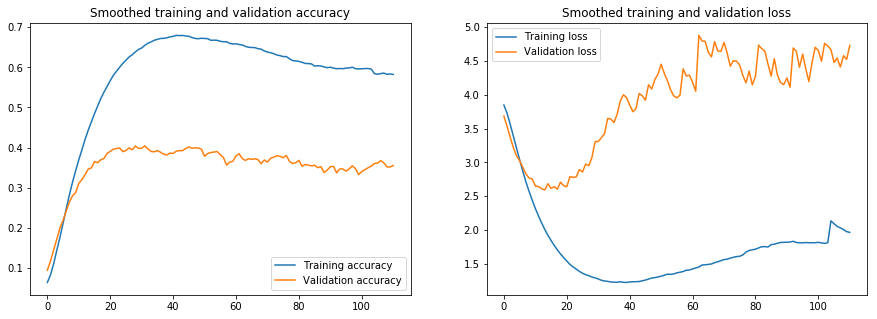

In [16]:
plot_smoothed_acc_and_loss(history, 0.8)

# 120 breeds

### Data preparation

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

with open('classes_encoding_120', 'wb') as f:
    pickle.dump(classes_labels, f)

Found 12307 images belonging to 120 classes.
Found 4111 images belonging to 120 classes.
Found 4162 images belonging to 120 classes.

Stored classes labels in classes_labels:  ['Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Blenheim_spaniel', 'Border_collie', 'Border_terrier', 'Boston_bull', 'Bouvier_des_Flandres', 'Brabancon_griffon', 'Brittany_spaniel', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Dandie_Dinmont', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'French_bulldog', 'German_shepherd', 'German_short', 'Gordon_setter', 'Great_Dane', 'Great_Pyrenees', 'Greater_Swiss_Mountain_dog', 'Ibizan_hound', 'Irish_setter', 'Irish_terrier', 'Irish_water_spaniel', 'Irish_wolfhound', 'Italian_greyhound', 'Japanese_spaniel', 'Kerry_blue_terrier', 'Labrador_retriever', 'Lakeland_terrier', 'Leonberg', 'Lhasa', '

### Model

In [4]:
model = load_model(PATH + 'tl_freeze_conv_base_data_aug_120')

W0630 23:51:48.426599  3848 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0630 23:51:48.446600  3848 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0630 23:51:48.469601  3848 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0630 23:51:49.184642  3848 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0630 23:51:49.185642  3848 de

In [5]:
set_trainable = False
for layer in model.layers[0].layers:
    if layer.name == 'block4_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [6]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['accuracy'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_fine_tuning_120', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_fine_tuning_120_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 137s - loss: 4.4572 - acc: 0.0462 - val_loss: 3.9669 - val_acc: 0.0844

Epoch 00001: val_loss improved from inf to 3.96687, saving model to tl_fine_tuning_120
Epoch 2/1000
 - 135s - loss: 3.7401 - acc: 0.1231 - val_loss: 3.4938 - val_acc: 0.1755

Epoch 00002: val_loss improved from 3.96687 to 3.49383, saving model to tl_fine_tuning_120
Epoch 3/1000
 - 134s - loss: 3.4371 - acc: 0.1666 - val_loss: 3.2529 - val_acc: 0.2024

Epoch 00003: val_loss improved from 3.49383 to 3.25294, saving model to tl_fine_tuning_120
Epoch 4/1000
 - 134s - loss: 3.1846 - acc: 0.2066 - val_loss: 3.2546 - val_acc: 0.2200

Epoch 00004: val_loss did not improve from 3.25294
Epoch 5/1000
 - 134s - loss: 3.0126 - acc: 0.2427 - val_loss: 3.0387 - val_acc: 0.2381

Epoch 00005: val_loss improved from 3.25294 to 3.03868, saving model to tl_fine_tuning_120
Epoch 6/1000
 - 134s - loss: 2.8729 - acc: 0.2752 - val_loss: 2.9861 - val_acc: 0.2662

Epoch 00006: val_loss improved from 3.03868 to 2.98607, savin


Epoch 00057: val_loss did not improve from 2.63412
Epoch 58/1000
 - 133s - loss: 2.1576 - acc: 0.4756 - val_loss: 3.5067 - val_acc: 0.3158

Epoch 00058: val_loss did not improve from 2.63412
Epoch 59/1000
 - 133s - loss: 2.2151 - acc: 0.4650 - val_loss: 3.4090 - val_acc: 0.3126

Epoch 00059: val_loss did not improve from 2.63412
Epoch 60/1000
 - 133s - loss: 2.2371 - acc: 0.4541 - val_loss: 4.1962 - val_acc: 0.3178

Epoch 00060: val_loss did not improve from 2.63412
Epoch 61/1000
 - 133s - loss: 2.2042 - acc: 0.4597 - val_loss: 3.6209 - val_acc: 0.3173

Epoch 00061: val_loss did not improve from 2.63412
Epoch 62/1000
 - 133s - loss: 2.2664 - acc: 0.4611 - val_loss: 3.9008 - val_acc: 0.3082

Epoch 00062: val_loss did not improve from 2.63412
Epoch 63/1000
 - 133s - loss: 2.2314 - acc: 0.4643 - val_loss: 3.9570 - val_acc: 0.2970

Epoch 00063: val_loss did not improve from 2.63412
Epoch 64/1000
 - 133s - loss: 2.2472 - acc: 0.4582 - val_loss: 4.4823 - val_acc: 0.3417

Epoch 00064: val_lo

### Results

In [7]:
model.evaluate(test_features, test_labels)

4162/4162 [==============================] - 17s 4ms/step


[2.613286925530789, 0.3209995194617972]

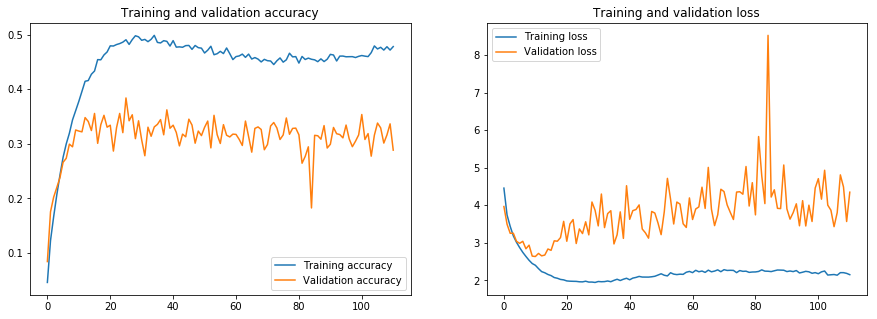

In [8]:
plot_accuracy_and_loss(history)

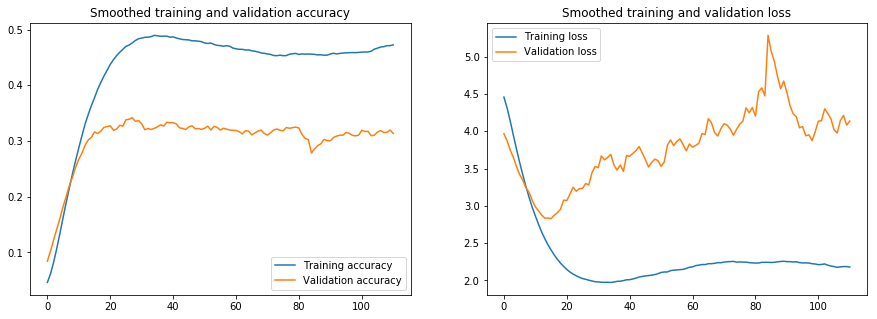

In [9]:
plot_smoothed_acc_and_loss(history, 0.8)